# Beispiel 18.4: Gas-Flüssig-Reaktion 1. Ordnung in einem Rührkesselreaktor
Bearbeitet von Franz Braun

Dieses Beispiel befindet sich im Lehrbuch auf den Seiten 284 - 287. Die Nummerierung
der verwendeten Gleichungen entspricht der Nummerierung im Lehrbuch. Das hier angewendete
Vorgehen entspricht dem im Lehrbuch vorgestellten Lösungsweg.

Zunächst werden die benötigten Pakete importiert.

In [1]:
### Import
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from tabulate import tabulate

Die Reaktionskinetik für die betrachtete Reaktion ($\mathrm{A_1} \rightarrow \mathrm{A_3}$) ist geben als:

\begin{align*}
r_\mathrm{L} = k\, c_{c_1,\mathrm{L}}.
\end{align*}

Für die Komponenten $\mathrm{A_1}$ und $\mathrm{A_3}$ ergeben sich die dimensionslosen Materialbilanzen für eine Reaktion 1. Ordnung im flüssigkeitsseitigen Grenzfilm (Mesoskala) aus Gleichung 18.15a zu:

\begin{align*}
\frac{\mathrm{d} f_\mathrm{1,L}^2}{\mathrm{d}^2\chi} &=  Ha^2 f_\mathrm{1,L},\\
\frac{\mathrm{d} f_\mathrm{3,L}^2}{\mathrm{d}^2\chi} &= -Ha^2 f_\mathrm{1,L}.
\end{align*}

Die Materialbilanzen werden in folgender Funktion implementiert.

In [2]:
def material(X, y):
    '''
    Dimensionslose Materialbilanz (Mesoskala) für die Reaktion 2.Ordnung (Gleichung 18.15a)
    y[0]       : Restanteil von A1
    y[1]       : Restanteil von A3
    y[2]       : erste Ableitung des Restanteils von A1 nach der dimensionslosen Ortskoordinate
    y[3]       : erste Ableitung des Restanteils von A3 nach der dimensionslosen Ortskoordinate
    dy2dX2     : zweite Ableitung der Restanteile von nach der dimensionslosen Ortskoordinate (Vektor der Größe 2)
    X          : Ortskoordinate
    '''
    f = y[:2]  # Vektor für die Restanteile von A1 und A2 

    dy2dX2 = np.empty_like(y[2:])
    
    dy2dX2[0] =   Ha**2 * f[0]
    dy2dX2[1] = - Ha**2 * f[0]
    

    return np.vstack((y[2:],dy2dX2))

Die dazugehörigen Randbedingungen an der Grenzfläche zwischen flüssigkeitsseitigem Grenzfilm und Kernströmung, also für $\chi = 1$,
lauten unter der Annahme $D_\mathrm{1,L} = D_\mathrm{3,L}$ (s. Gleichung 18.17):

\begin{align*}
f_\mathrm{1,L}(\chi = 1) & = f_\mathrm{1,L,b},\\
f_\mathrm{3,L}(\chi = 1) & = f_\mathrm{3,L,b}.
\end{align*}

An der Stelle $\chi = 0$ (Phasengrenzfläche) werden gem. Gleichung 18.16 folgende Randbedingungen angesetzt (Erläuterung Lehrbuchtext zu Beispiel 18.4):

\begin{align*}
f_\mathrm{1,L}(\chi = 0) & = f_\mathrm{1,G,b},\\
\frac{\mathrm{d} f_\mathrm{3,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}\normalsize & = 0.
\end{align*}

Für die Berechnung der erforderlichen Restanteile von $A_1$ und $A_3$ in der Kernströmung der Flüssigkeit $f_{i,\mathrm{L,b}}$ werden die Bilanzgleichungen auf der Reaktorskala (Mesoskala) auf Basis von Gleichung 18.38b formuliert. Es wird angenommen, dass $c_\mathrm{1,L,e} = c_\mathrm{3,L,e} = 0$. Es ergibt sich:

\begin{align*}
0 &= - f_\mathrm{1,L,b} - \frac{Da_\mathrm{I}}{Hi \, Ha^2} \frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1} \normalsize - Da_\mathrm{I} \frac{Hi - 1 }{Hi} f_\mathrm{1,L,b},\\
0 &= - f_\mathrm{3,L,b} - \frac{Da_\mathrm{I}}{Hi \, Ha^2} \frac{\mathrm{d} f_\mathrm{3,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1} \normalsize + Da_\mathrm{I} \frac{Hi - 1 }{Hi} f_\mathrm{1,L,b},
\end{align*}

bzw. nach dem Restanteil in der Kernströmung $f_{i,\mathrm{L,b}}$ umgestellt:

\begin{align*}
f_\mathrm{1,L,b}&=  - \frac{Da_\mathrm{I}}{Hi \, Ha^2} \frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1} \normalsize - Da_\mathrm{I} \frac{Hi - 1 }{Hi} f_\mathrm{1,L,b},\\
f_\mathrm{3,L,b}&=  - \frac{Da_\mathrm{I}}{Hi \, Ha^2} \frac{\mathrm{d} f_\mathrm{3,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1} \normalsize + Da_\mathrm{I} \frac{Hi - 1 }{Hi} f_\mathrm{1,L,b},
\end{align*}

Die Randbedingungen werden in der Funktion _bc_material_ implementiert, die auch die Berechung der Restanteile in der Kernströmung enthält.

In [3]:
def bc_material(y0, y1):
    '''
    Randbedingungen der Materialbilanz
    y0    : Randbedingungen bei X = 0; 
                Vektor der Größe 4 : (Restanteil A1, Restanteil A3, Ableitung des Restanteils A1 nach der Ortskoordinate, Ableitung des Restanteils A3 nach der Ortskoordinate)
    y1    : Randbedingungen bei X = 1;
                Vektor der Größe 4 : (Restanteil A1, Restanteil A3, Ableitung des Restanteils A1 nach der Ortskoordinate, Ableitung des Restanteils A3 nach der Ortskoordinate)
    f_L_b : Restanteil von A1 und A3 in der Kernströmung
    f_G_b : Restanteil von A1 und A3 im Bulk des Gases
    '''

    # Berechnung der Restanteile in der Kernströmung der Flüssigkeit f_L_b (Bilanz Makroskala)
    f_L_b    = np.zeros(2)
    f_L_b[0] = - Da_I / (Hi * Ha**2) * y1[2] - Da_I * (Hi - 1) / Hi * y1[0]  # Restanteil von A1 in der Kernströmung
    f_L_b[1] = - Da_I / (Hi * Ha**2) * y1[3] + Da_I * (Hi - 1) / Hi * y1[0]  # Restanteil von A3 in der Kernströmung


    BC = np.empty(nu.size *2)  # 2 Randbedingungen (RB) pro Komponente
    # A1
    BC[0] = y0[0] - f_1_G_b    # RB an der Stelle X = 0 für Komponente A1 : 0 = f_1,L(X = 0) - f_1,G,b
    BC[1] = y1[0] - f_L_b[0]   # RB an der Stelle X = 1 für Komponente A1 : 0 = f_1,L(X = 1) - f_1,L,b
    # A3
    BC[2] = y0[3]              # RB an der Stelle X = 0 für Komponente A3 : 0 = df_3dX(X = 0)
    BC[3] = y1[1] - f_L_b[1]   # RB an der Stelle X = 1 für Komponente A3 : 0 = f_3,L(X = 1) - f_3,L,b
    
    return BC

Danach werden die stöchiometrischen Koeffizienten gemäß der Reaktionsgleichung, die Hatta-Zahl und der Restanteil von $A_1$ in der Kernströmung des Gases parametriert. 

In [4]:
Ha          = 0.3                 # Hatta-Zahl
nu          = np.array((-1, 1))   # Stöchiometrische Koeffizienten für A1, A3 
f_1_G_b     = np.array((1))       # Restanteil von A1 in der Kernströmung des Gases

Da der Einfluss verschiedener  Dammköhler-Zahlen $(Da_I)$ und Hinterland-Verhältnisse $(Hi)$ betrachtet werden soll, erfolgt die Variation von $Da_I$ und $Hi$ jeweils in einer For-Schleife. Die Profile der Restanteile werden durch den Aufruf eines Solvers für Randwertprobleme (solve_bvp) auf Grundlage der Materialbilanzen und der Randbedingungen berechnet.

In [5]:
Da_I_vec   = np.array((1, 3, 10))              # Vektor mit Dammköhler-Zahlen für Beispiel 18.4
Hi_vec     = np.array((1, 10, 100, 1000))      # Vektor mit Hinterland-Verhältnissen für Beispiel 18.4

Lösungen_Hi = []                               # Leere Liste zum Speichern der Lösungen für die verschiedenen Hinterland-Verhältnisse
Lösungen_Da = []                               # Leere Liste zum Speichern der Lösungen für die verschiedenen Dammköhler-Zahlen
N           = 101                              # Diskretisierung
X           = np.linspace(0, 1, N)             # Diskretisierung der Ortskoordinate
init_f      = np.ones((2, N))                  # Startwerte für Restanteile
init_df     = np.ones((2, N))*1e-5             # Startwerte für die Ableitungen der Restanteile
init        = np.vstack((init_f, init_df))     # Zusammengefügte Startwerte für die Iterationen des Solvers


for HiHi in Hi_vec:
    Da_I = Da_I_vec[1]
    Hi   = HiHi
    sol  = solve_bvp(material, bc_material, X, init , max_nodes = 1e10, tol = 1e-10)
    if sol.success == False:
        print(sol)
    Lösungen_Hi.append(sol)


for DaDa in Da_I_vec:
    Hi   = Hi_vec[2]
    Da_I = DaDa
    sol  = solve_bvp(material, bc_material, X, init , max_nodes = 1e10, tol = 1e-10)
    if sol.success == False:
        print(sol)
    Lösungen_Da.append(sol)

Lösungen_Hi = np.array((Lösungen_Hi))
Lösungen_Da = np.array((Lösungen_Da))

 Abschließend werden die Ergebnisse grafisch veranschaulicht.

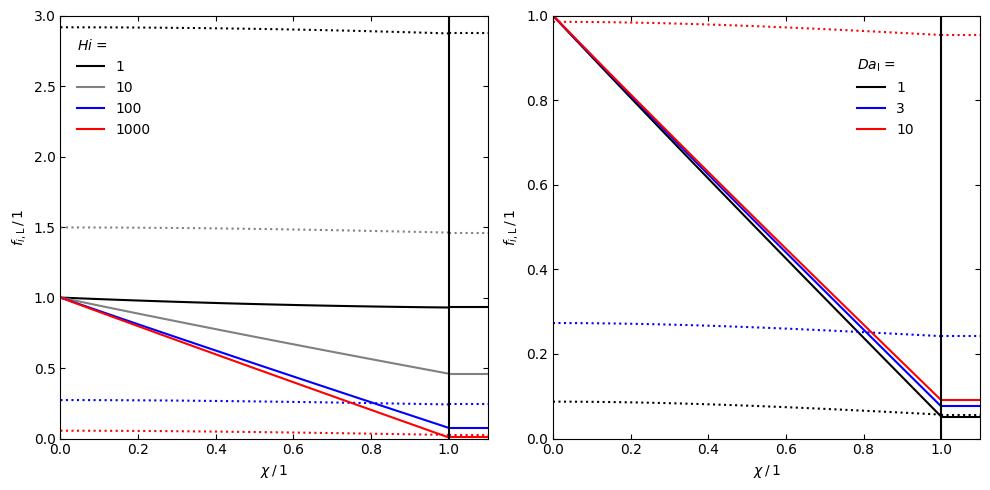

In [6]:
colors_Hi = ['black','gray','blue','red']
colors_Da = ['black','blue','red']

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for Lösung, Hi, color in zip(Lösungen_Hi,Hi_vec,colors_Hi):
    ax[0].plot(Lösung.x, Lösung.y[0], label = str(Hi), color = color)
    ax[0].hlines(y=Lösung.y[0][-1], xmin=1, xmax=1.1, colors = color)
    ax[0].plot(Lösung.x, Lösung.y[1], color = color, linestyle = ':')
    ax[0].hlines(y=Lösung.y[1][-1], xmin=1, xmax=1.1, colors = color, linestyle = ':')

for Lösung, Da, color in zip(Lösungen_Da,Da_I_vec,colors_Da):
    ax[1].plot(Lösung.x, Lösung.y[0], label = str(Da), color = color)
    ax[1].hlines(y=Lösung.y[0][-1], xmin=1, xmax=1.1, colors = color)
    ax[1].plot(Lösung.x, Lösung.y[1], color = color, linestyle = ':')
    ax[1].hlines(y=Lösung.y[1][-1], xmin=1, xmax=1.1, colors = color, linestyle = ':')

ax[0].vlines(x=1, ymin=0, ymax=3, colors='black')
ax[0].set_xlim(0,1.1)
ax[0].set_ylim(0,3)
ax[0].tick_params(axis="y",direction="in", right = True)
ax[0].tick_params(axis="x",direction="in", top = True)
ax[0].set_ylabel(r'$f_{i,\mathrm{L}}\,/\,1$')
ax[0].set_xlabel(r'$\chi \,/\,1$')
ax[0].legend(title = '$Hi$ =',frameon = False, alignment = 'left',ncol=1,loc=(0.025,0.7))

ax[1].vlines(x=1, ymin=0, ymax=3, colors='black')
ax[1].set_ylabel(r'$f_{i,\mathrm{L}}\,/\,1$')
ax[1].set_xlabel(r'$\chi \,/\,1$')
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1)
ax[1].tick_params(axis="y",direction="in", right = True)
ax[1].tick_params(axis="x",direction="in", top = True)
ax[1].legend(title = '$Da_\mathrm{I}$ =',frameon = False, alignment = 'left',ncol=1,loc=(0.7,0.7))
plt.tight_layout()
plt.show()

Für die Betrachtung des Einflusses von $Hi$ und $Da_\mathrm{I}$ auf den Nutzungsgrad des Flüssigkeitsfilms $\eta_\mathrm{L,Film}$, den Nutzungsgrad der Kernströmung $\eta_\mathrm{L,b}$, den Nutzungsgradverlust $\Delta\eta_\mathrm{L}$ und den Verstärkungsfaktor $E$ werden folgende Gleichungen ausgewertet (s. Beispiel im Lehrbuch):

\begin{align*}
E &= \frac{\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}}{f_{1,\chi = 1}-f_{1,\chi = 0}} \\
\eta_\mathrm{L,Film} &= 1 - \frac{\dot{n}_{1,\chi = 1}}{\dot{n}_{1,\chi = 0}} = 1 - \frac{J_{1,\chi = 1}}{J_{1,\chi = 0}} = 1 - \frac{\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 1}}{\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}}\\
\Delta\eta_\mathrm{L} &= \frac{\dot{n}_\mathrm{1,L,a} - \dot{n}_\mathrm{1,L,e}}{\dot{n}_{1,\chi = 0}} = - \frac{Hi\,Ha^2}{Da_\mathrm{I}} \frac{f_\mathrm{1,L,b}}{\frac{\mathrm{d} f_\mathrm{1,L}}{\mathrm{d}\chi} \Big \vert_{\chi = 0}}\\
\eta_\mathrm{L,b} &= 1 - \eta_\mathrm{L,Film} - \Delta\eta_\mathrm{L}
\end{align*}

Diese Berechnungsvorschriften werden jeweils als Funktionen wie folgt implementiert.

In [7]:
def cal_E(dfdx_0, f_0, f_1):
    '''
    Berechnung des Verstärkungsfaktors
    dfdx_0 : Ableitung des Restanteils nach der Ortskoordinate an der Stelle X = 0
    f_0    : Restanteil an der Stelle X = 0
    f_1    : Restanteil an der Stelle X = 1
    '''
    return dfdx_0 / (f_1 - f_0)

def cal_eta_L_Film(dfdx_1, dfdx_0):
    '''
    Berechnung des Nutzungsgrads des Flüssigkeitsfilms
    dfdx_1 : Ableitung des Restanteils nach der Ortskoordinate an der Stelle X = 1
    dfdx_0 : Ableitung des Restanteils nach der Ortskoordinate an der Stelle X = 0
    '''
    return 1 - dfdx_1 / dfdx_0


def cal_Delta_eta_L(Hi, Ha, Da, f_1_L_b, dfdx_0):
    '''
    Berechnung des Nutzungsgradverlusts
    dfdx_0  : Ableitung des Restanteils nach der Ortskoordinate an der Stelle X = 0
    Hi      : Hinterland-Verhältnis
    Da      : Dammköhler-Zahl
    Ha      : Hatta-Zahl
    f_1_L_b : Restanteil von A1 in der Kernströmung der Flüssigkeit
    '''
    return - Hi * Ha**2 / Da * f_1_L_b / dfdx_0

def cal_eta_L_b(eta_L_Film, Delta_eta_L):
    '''
    Berechnung des NUtzungsgrads der Kernströmung
    eta_L_Film  : Nutzungsgrads des Flüssigkeitsfilms
    Delta_eta_L : Nutzungsgradverlust
    '''
    return 1 - eta_L_Film - Delta_eta_L

Die Berechnungen für verschiedene $Hi$ und $Da_\mathrm{I}$ erfolgen jeweils in einer For-Schleife.

In [8]:
# Berechnungen für Da_I = 3
Res_Hi_var = [] # leere Liste zum Speichern der Ergebnisse für verschiedene Hi

for Lösung, Hi in zip(Lösungen_Hi, Hi_vec):
    Da     = 3
    Res    = np.empty(4) # Array der Größe 4 zum Speichern von E, eta_L_Film, Delta_eta_L, eta_L_b
    Res[0] = cal_E(Lösung.y[2,0], Lösung.y[0,0], Lösung.y[0,-1])
    Res[1] = cal_eta_L_Film(Lösung.y[2,-1], Lösung.y[2,0])
    Res[2] = cal_Delta_eta_L(Hi, Ha, Da, Lösung.y[0,-1], Lösung.y[2,0])
    Res[3] = cal_eta_L_b(Res[1],Res[2])
    Res_Hi_var.append(Res)

Res_Hi_var = np.array((Res_Hi_var))



# Berechnungen für Hi = 100
Res_Da_var = [] # leere Liste zum Speichern der Ergebnisse für verschiedene Da

for Lösung, Da in zip(Lösungen_Da,Da_I_vec):
    Hi     = 100
    Res    = np.empty(4) # Array der Größe 4 zum Speichern von E, eta_L_Film, Delta_eta_L, eta_L_b
    Res[0] = cal_E(Lösung.y[2,0], Lösung.y[0,0], Lösung.y[0,-1])
    Res[1] = cal_eta_L_Film(Lösung.y[2,-1], Lösung.y[2,0])
    Res[2] = cal_Delta_eta_L(Hi, Ha, Da, Lösung.y[0,-1], Lösung.y[2,0])
    Res[3] = cal_eta_L_b(Res[1], Res[2])
    Res_Da_var.append(Res)

Res_Da_var      = np.array((Res_Da_var))

comb_Res        = np.hstack((Res_Hi_var.T, Res_Da_var.T)) # Kombinierter Vektor der Ergebnisse
comb_Res[[2,3]] = comb_Res[[3,2]]                        # Tauschen der letzten mit der vorletzten Reihe

Die Ergebnisse werden in einer Tabelle ausgegeben.

In [9]:
# Ausgabe der Ergebnisse als Tabelle

names_y  = np.array((['Hi / 1'], ['Da_I / 1'], ['E / 1'], ['eta_L_Film / 1'], ['eta_L_b / 1'], ['Delta_eta_L / 1']))
Hi_table = np.array((1, 10, 100, 1000, 100, 100, 100))  
Da_table = np.array((3, 3, 3, 3, 1, 3, 10))

# Array for table
table = np.hstack((names_y,np.vstack((Hi_table, Da_table, abs(np.round(comb_Res, 2))))))

print(tabulate(table))

---------------  ----  -----  ------  -------  ------  ------  ------
Hi / 1           1     10     100     1000     100     100     100
Da_I / 1         3      3       3        3       1       3      10
E / 1            1.62   1.07    1.03     1.03    1.03    1.03    1.03
eta_L_Film / 1   0.76   0.11    0.05     0.04    0.05    0.05    0.05
eta_L_b / 1      0      0.65    0.71     0.72    0.47    0.71    0.86
Delta_eta_L / 1  0.24   0.24    0.24     0.24    0.48    0.24    0.09
---------------  ----  -----  ------  -------  ------  ------  ------
